In [1]:
!jt -t  grade3

zsh:1: command not found: jt


In [2]:
#modularize the code to avoid repeating blocks

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.interpolate as interp
from astropy.io.votable import parse_single_table
from __future__ import division
from scipy.stats import gaussian_kde
import popsims
from tqdm import tqdm
import matplotlib as mpl
import seaborn as sns
sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
mpl.rc('image', cmap='cividis')
WFIRSTlimits = [30.0,30.0] #limiting magnitudes used for WFIRS
%matplotlib inline

In [4]:
path_plot = '/users/caganze/research/stellarstreams/figures/isochrones/'
path_data = '/users/caganze/research/stellarstreams/data/isochrones/'

In [5]:
plt.style.use('dark_background') #for posters

In [6]:
def kde(x, x_num, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    x_tot = np.asarray([])
    for i in range(len(x)):
        x_tot = np.concatenate((x_tot, np.repeat(x[i], int(x_num[i]))), axis = 0)
    kde = gaussian_kde(x_tot)
    return kde.evaluate(x_grid)


def generate_rand_from_pdf(pdf, x_grid, num):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

def generate_foreground():
    
    pass

def generate_additional_stars():
    ## Go through all different distances used
    for i in range(8):
        if i == 0: dist_mod = dist_mod_And #M31
        elif i >= 1: dist_mod = 6 + 2*i #MW disk, inner halo, and outer halo
        ## go through all metallicities and ages for this distance
        for j in range(16):
            start_isochrone = start_age[j]
            if j == len(start_age)-1:
                end_isochrone = len(wfirst_mags[:,0])-1
            else:
                end_isochrone = start_age[j+1]-1
            inter_Rmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                            wfirst_mags[start_isochrone:end_isochrone,0], assume_sorted = False, fill_value = "extrapolate")
            inter_Ymags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                            wfirst_mags[start_isochrone:end_isochrone,2], assume_sorted = False, fill_value = "extrapolate")
            inter_Jmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                            wfirst_mags[start_isochrone:end_isochrone,3], assume_sorted = False, fill_value = "extrapolate")
            inter_Hmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                            wfirst_mags[start_isochrone:end_isochrone,4], assume_sorted = False, fill_value = "extrapolate")
            inter_Fmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                            wfirst_mags[start_isochrone:end_isochrone,5], assume_sorted = False, fill_value = "extrapolate")
            ## read in the luminosity function in all WFIRST bands for this metallicity and age - isochrone
            ## the luminosity functions are created drawing 1e5 stars from an IMF for this isochrone
            lumfunc = np.loadtxt(path_data+'/WFIRST_PARSEC_lumfunc_isochrone%d_allbands.txt' %j)
            ## count the number of stars assigned to this isochrone (distance, age, metallicity)
            numstars = np.sum(np.logical_and(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)],
                                          matchAge == isos[np.asarray(start_age),1][j%4]), matchgal == i))
            print ('i = ', i, '# stars in isochrone:', j, numstars)
            feh = isos[np.asarray(start_feh),0][int(j/4)]
            limits = [np.max(magsIn[:,0]), np.max(magsIn[:,1])]
            if numstars > 0:
                ## check how many stars (of the 1e5 total) there are in the luminosity function within the PANDAS limits.
                numunderlim = np.asarray([np.sum(lumfunc[lumfunc[:,0] + dist_mod < limits[0],1]), 
                    np.sum(lumfunc[lumfunc[:,2] + dist_mod < limits[1],3])])
                #print 'number of 1e5 stars luminosity function under old limits of', limits, ':', numunderlim

                ## check how many stars (of the 1e5 total) there should be in the luminosity function within the WFIRST limits.
                newnumunderlim = np.asarray([np.sum(lumfunc[lumfunc[:,0] + dist_mod < WFIRSTlimits[0],1]), 
                    np.sum(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3])])
                #print 'number of 1e5 stars luminosity function under new limits of', WFIRSTlimits, ':',  newnumunderlim

                ## calculate how many stars need to be added for the WFIRST limits, 
                ## using the relative number of stars in the luminosity function within the WFIRST and PANDAS limits,
                ## and the number of stars matched to this isochrone in the PANDAS data
                newnumstars = np.round(numstars*newnumunderlim[1]*1.0/numunderlim[1]).astype('int')
                newnumstars0 = np.round(numstars*newnumunderlim[0]*1.0/numunderlim[0]).astype('int')
                print ("newnumstars R and Z: ", newnumstars0, newnumstars)
                addstars = newnumstars - numstars
                print (" need to add stars: ", addstars, "to", newnumstars)
                ## Estimate the KDE of the Z magnitude from the PANDAS stars over the Z-magnitude from the isochrone
                ## and randomly draw all stars (not just the added ones) from the KDE
                x_grid_Z = np.linspace(np.min(wfirst_mags[start_isochrone:end_isochrone,1] + dist_mod), 
                                       np.min([WFIRSTlimits[1], np.max(wfirst_mags[start_isochrone:end_isochrone,1]) + dist_mod]), 
                                       newnumstars)
                kdepdf_Z = kde(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],2] + dist_mod,
                           lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3], x_grid_Z)
                random_Z = generate_rand_from_pdf(kdepdf_Z, x_grid_Z, newnumstars)
                ## Use the interpolate relation between Z and other bands from the isochrone to 
                ## estimate the other magnitudes for all new stars
                random_R = inter_Rmags(random_Z - dist_mod) + dist_mod
                random_H = inter_Hmags(random_Z - dist_mod) + dist_mod
                random_Y = inter_Ymags(random_Z - dist_mod) + dist_mod
                random_J = inter_Jmags(random_Z - dist_mod) + dist_mod
                random_F = inter_Fmags(random_Z - dist_mod) + dist_mod
                ## randomly assign position (xki and eta) for all new stars
                random_xki = np.random.uniform(low = np.min(locIn[:,0]), high = np.max(locIn[:,0]), size = newnumstars)
                random_eta = np.random.uniform(low = np.min(locIn[:,1]), high = np.max(locIn[:,1]), size = newnumstars)
                if newstars.size == 0:
                    newstars = np.concatenate((np.reshape(random_xki, (len(random_xki),1)), 
                                            np.reshape(random_eta, (len(random_eta),1)), 
                                            np.reshape(random_R, (len(random_R),1)), 
                                            np.reshape(random_Z, (len(random_Z),1)), 
                                            np.reshape(random_Y, (len(random_Y),1)), 
                                            np.reshape(random_J, (len(random_J),1)),
                                            np.reshape(random_H, (len(random_H),1)), 
                                            np.reshape(random_F, (len(random_F),1)),
                                            np.reshape(np.repeat(np.log10(feh*1.0/0.0152), len(random_xki))
                                                    , (len(random_xki),1))), axis = 1)
                else:
                    newstars = np.concatenate((newstars, np.concatenate((np.reshape(random_xki, (len(random_xki),1)), 
                                            np.reshape(random_eta, (len(random_eta),1)), 
                                            np.reshape(random_R, (len(random_R),1)), 
                                            np.reshape(random_Z, (len(random_Z),1)), 
                                            np.reshape(random_Y, (len(random_Y),1)), 
                                            np.reshape(random_J, (len(random_J),1)),
                                            np.reshape(random_H, (len(random_H),1)), 
                                            np.reshape(random_F, (len(random_F),1)),
                                            np.reshape(np.repeat(np.log10(feh*1.0/0.0152), len(random_xki))
                                                    , (len(random_xki),1))), axis = 1)), axis = 0)
                print ('new number of stars in isochrone under new limits', newnumstars, ':', addstars, "added")


    #newstars = np.asarray(newstars)


DO for WFIRST on M31 field 10-20 kpc

In [7]:
## Load the PANDAS field corrected to magnitudes in R and Z WFIRST filters: location, R, Z, and metallicity.
locIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_10_20kpc_new.vot.txt', skiprows = 1, usecols = [4,5])
magsIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_10_20kpc_new.vot.txt', skiprows = 1, usecols = [0,1])
fehIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_10_20kpc_new.vot.txt', skiprows = 1, usecols = [6])

## load the 16 isochrones that we use to fit the stars to
isos = np.loadtxt(path_data+'/WFIRST_PARSEC_isochrones_grid.txt')
#dist_mod_And = 16.8553 + 7.6 #Sarah's old estimate for Andromeda
dist_mod_And = 24.47 #from Ibata+2014

In [8]:
## know where new ischrones start in the "isos" isochrone-grid (different ages and different metallicities)
all_iso = []
start_feh = [0,0,0,0]
start_age = np.repeat(0,16)
j_feh = 1
j_age = 1
for i in range(len(isos[:,0])-1):
    if (isos[i+1,0] != isos[i,0]):
        start_feh[j_feh] = i+1
        j_feh = j_feh + 1
    if (isos[i+1,1] != isos[i,1]):
        start_age[j_age] = i+1
        j_age = j_age + 1

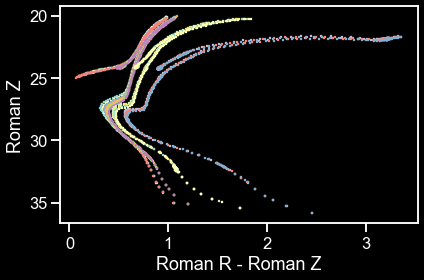

In [17]:
fig, ax=plt.subplots()
for j in range(15):
    _= ax.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 3, marker='+')

ax.set(xlabel='Roman R - Roman Z', ylabel='Roman Z')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../figures/ischrones.jpeg')

In [10]:
bjkl

NameError: name 'bjkl' is not defined

In [ ]:
#double check the metallicities with the convention that we use (solar is 0.0152)
print (np.log10(isos[start_feh,0]/0.0152))

In [ ]:
#magsIn[:,]

In [ ]:
##For every star in PANDAS (in the list magsIn): 
## estimate the distance to the points of all isochrones, in 2D: color and Z magnitude
## and assign the metallicity and age of the closest isochrone
## Also assign at what distance the isochrone is put: M31 distance (0) or closer, i.e. MW disk or halo: > 0.
## We need to include isochrones for the MW disk and halo, because there still is quite some contamination in the PANDAS fields

match = np.zeros(len(magsIn[:,0]))
matchFeH = np.zeros(len(magsIn[:,0]))
matchAge = np.zeros(len(magsIn[:,0]))
matchgal = np.zeros(len(magsIn[:,0]))
print (len(match), len(isos[:,13]))
range1 = np.max(np.concatenate((magsIn[:,1], isos[:,11] + dist_mod_And,
                                isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                                isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0))
- np.min(np.concatenate((magsIn[:,1], isos[:,11] + dist_mod_And,
                         isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                         isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0))
range2 = np.max(np.concatenate((magsIn[:,0]-magsIn[:,1], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0))
- np.min(np.concatenate((magsIn[:,0]-magsIn[:,1], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                         isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11],
                         isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0))
for i in range(len(magsIn[:,0])):
    rescale_dist1 = (magsIn[i,1] - np.concatenate((isos[:,11] + dist_mod_And,
                                isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                                isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0)) / range1
    rescale_dist2 = ((magsIn[i,0]-magsIn[i,1]) - np.concatenate((isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0)) / range2
    match[i] = np.argmin(np.sqrt(rescale_dist1**2 + rescale_dist2**2))
    if np.logical_and(match[i] < start_age[1], match[i] >= start_age[0]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[2], match[i] >= start_age[1]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[3], match[i] >= start_age[2]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[4], match[i] >= start_age[3]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[5], match[i] >= start_age[4]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[6], match[i] >= start_age[5]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[7], match[i] >= start_age[6]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[8], match[i] >= start_age[7]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[9], match[i] >= start_age[8]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[10], match[i] >= start_age[9]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[11], match[i] >= start_age[10]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[12], match[i] >= start_age[11]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[13], match[i] >= start_age[12]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[14], match[i] >= start_age[13]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[15], match[i] >= start_age[14]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < len(isos[:,13]), match[i] >= start_age[15]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif match[i] > len(isos[:,13]) + start_age[0]:
        MWmatch = match[i] % len(isos[:,13])
        if np.logical_and(MWmatch < start_age[1], MWmatch > start_age[0]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[2], MWmatch > start_age[1]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[3], MWmatch > start_age[2]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[4], MWmatch > start_age[3]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[5], MWmatch > start_age[4]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[6], MWmatch > start_age[5]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[7], MWmatch > start_age[6]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[8], MWmatch > start_age[7]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[9], MWmatch > start_age[8]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[10], MWmatch > start_age[9]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[11], MWmatch > start_age[10]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[12], MWmatch > start_age[11]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[13], MWmatch > start_age[12]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[14], MWmatch > start_age[13]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[15], MWmatch > start_age[14]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < len(isos[:,13]), match[i] >= len(isos[:,13]) + start_age[15]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')

        
print ("number of stars matched to FeH of isochrones:")
print (isos[np.asarray(start_feh),0][0], np.sum(matchFeH == isos[np.asarray(start_feh),0][0]))
print (isos[np.asarray(start_feh),0][1], np.sum(matchFeH == isos[np.asarray(start_feh),0][1]))
print (isos[np.asarray(start_feh),0][2], np.sum(matchFeH == isos[np.asarray(start_feh),0][2]))
print (isos[np.asarray(start_feh),0][3], np.sum(matchFeH == isos[np.asarray(start_feh),0][3]))
print ("number of stars matched to Age of isochrones:")
print (10.0**isos[np.asarray(start_age),1][0]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][0]))
print (10.0**isos[np.asarray(start_age),1][1]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][1]))
print (10.0**isos[np.asarray(start_age),1][2]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][2]))
print (10.0**isos[np.asarray(start_age),1][3]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][3]))

print ("galaxy")
print ("MW", np.sum(matchgal >= 1))
print ("M31", np.sum(matchgal == 0))

In [ ]:
## Plot for each age and metallicity the isochrones at differernt distances, and the stars assigned to those isochrones.
## Note how many stars are assigned to these isochrones, 
## and how many of those to the M31-isochrone of this age and metallicity

fig, axes = plt.subplots(4,4, figsize = [20,20])
for j in range(16):
    axes[j%4,int(j/4)].hist2d((magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),0]
                -magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),1]), 
               magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),1], 
               bins = 50, range = [[-1,4],[17,25]])
    if j == 15:
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + dist_mod_And, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 8, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 10, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 12, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 14, s = 2)        
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 16, s = 2)        
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 18, s = 2)       
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 20, s = 2)       
    else:
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 8, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 10, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 12, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 14, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 16, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 18, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 20, s = 2)
    axes[j%4,int(j/4)].text(2,23.5,'[Fe/H] = %0.1e' %(np.log10(isos[np.asarray(start_feh),0][int(j/4)]/0.0152)), color = 'white')
    axes[j%4,int(j/4)].text(2,24,'age = %0.1f Gyr' %(10.0**isos[np.asarray(start_age),1][j%4]/1e9), color = 'white')
    axes[j%4,int(j/4)].text(2,24.5,'# stars = %d' %(np.sum(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]))), color = 'white')
    axes[j%4,int(j/4)].text(2,25,'# stars And = %d' %(np.sum(np.logical_and(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]), matchgal == 0))), color = 'white')
    axes[j%4,int(j/4)].set_xlabel('R - Z')
    axes[j%4,int(j/4)].set_ylabel('Z')
    axes[j%4,int(j/4)].axis([-1,4,25,17])
    plt.tight_layout()

In [ ]:


## read in all WFIRST bands from the isochrone grid
wfirst_mags = np.loadtxt(path_data+'/WFIRST_PARSEC_isochrones_grid.txt', skiprows = 12, usecols = [10,11,12,13,14,15])
oldstars = np.concatenate((locIn, np.reshape(magsIn, (len(magsIn),2)), np.reshape(fehIn, (len(fehIn),1))), axis=1)
newstars = np.asarray([])


print (np.shape(newstars))
print (len(newstars[:,0]), len(oldstars[:,0]))

In [ ]:
#asdfghj

Do WFIRST for M31 field 30-40 kpc


In [ ]:
## Repeat as above for the field farther out in the M31 halo

locIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_30_40kpc_new.vot.txt', skiprows = 1, usecols = [4,5])
magsIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_30_40kpc_new.vot.txt', skiprows = 1, usecols = [0,1])
fehIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_30_40kpc_new.vot.txt', skiprows = 1, usecols = [6])

isos = np.loadtxt(path_data+'/WFIRST_PARSEC_isochrones_grid.txt')
dist_mod_And = 24.47 #from Ibata+2014

all_iso = []
start_feh = [0,0,0,0]
start_age = np.repeat(0,16)
j_feh = 1
j_age = 1
for i in range(len(isos[:,0])-1):
    if (isos[i+1,0] != isos[i,0]):
        start_feh[j_feh] = i+1
        j_feh = j_feh + 1
    if (isos[i+1,1] != isos[i,1]):
        start_age[j_age] = i+1
        j_age = j_age + 1

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = [18,6])
ax1.hist2d((magsIn[:,0]-magsIn[:,1]), magsIn[:,0], bins = 100, range = [[-1,4],[17,25]])
for j in range(15):
    ax1.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],10] + dist_mod_And, s = 2)
ax1.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,10] + dist_mod_And, s = 2)
ax1.set_xlabel('R - Z')
ax1.set_ylabel('R')
ax1.axis([-1,4,25,17])
ax2.hist2d((magsIn[:,0]-magsIn[:,1]), magsIn[:,1], bins = 100, range = [[-1,4],[17,25]])
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + dist_mod_And, s = 2)
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 12, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + 12, s = 2)
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 7, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + 7, s = 2)
ax2.set_xlabel('R - Z')
ax2.set_ylabel('Z')
ax2.axis([-1,4,25,17])
ax3.hist2d(magsIn[:,0], magsIn[:,1], bins = 50, range = [[17,25],[17,25]])
for j in range(15):
    ax3.scatter(isos[start_age[j]:start_age[j+1],10] + dist_mod_And, isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
ax3.scatter(isos[start_age[j+1]:,10] + dist_mod_And, isos[start_age[j+1]:,11]  + dist_mod_And, s = 2)
ax3.set_xlabel('R')
ax3.set_ylabel('Z')
ax3.axis([25,17,25,17])

In [ ]:
match = np.zeros(len(magsIn[:,0]))
matchFeH = np.zeros(len(magsIn[:,0]))
matchAge = np.zeros(len(magsIn[:,0]))
matchgal = np.zeros(len(magsIn[:,0]))
print (len(match), len(isos[:,13]))
range1 = np.max(np.concatenate((magsIn[:,1], isos[:,11] + dist_mod_And,
                                isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                                isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0))
- np.min(np.concatenate((magsIn[:,1], isos[:,11] + dist_mod_And,
                         isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                         isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0))
range2 = np.max(np.concatenate((magsIn[:,0]-magsIn[:,1], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0))
- np.min(np.concatenate((magsIn[:,0]-magsIn[:,1], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                         isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11],
                         isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0))
for i in range(len(magsIn[:,0])):
    rescale_dist1 = (magsIn[i,1] - np.concatenate((isos[:,11] + dist_mod_And,
                                isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                                isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0)) / range1
    rescale_dist2 = ((magsIn[i,0]-magsIn[i,1]) - np.concatenate((isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0)) / range2
    match[i] = np.argmin(np.sqrt(rescale_dist1**2 + rescale_dist2**2))
    if np.logical_and(match[i] < start_age[1], match[i] >= start_age[0]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[2], match[i] >= start_age[1]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[3], match[i] >= start_age[2]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[4], match[i] >= start_age[3]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[5], match[i] >= start_age[4]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[6], match[i] >= start_age[5]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[7], match[i] >= start_age[6]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[8], match[i] >= start_age[7]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[9], match[i] >= start_age[8]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[10], match[i] >= start_age[9]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[11], match[i] >= start_age[10]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[12], match[i] >= start_age[11]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[13], match[i] >= start_age[12]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[14], match[i] >= start_age[13]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[15], match[i] >= start_age[14]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < len(isos[:,13]), match[i] >= start_age[15]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif match[i] > len(isos[:,13]) + start_age[0]:
        MWmatch = match[i] % len(isos[:,13])
        if np.logical_and(MWmatch < start_age[1], MWmatch > start_age[0]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[2], MWmatch > start_age[1]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[3], MWmatch > start_age[2]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[4], MWmatch > start_age[3]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[5], MWmatch > start_age[4]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[6], MWmatch > start_age[5]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[7], MWmatch > start_age[6]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[8], MWmatch > start_age[7]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[9], MWmatch > start_age[8]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[10], MWmatch > start_age[9]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[11], MWmatch > start_age[10]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[12], MWmatch > start_age[11]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[13], MWmatch > start_age[12]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[14], MWmatch > start_age[13]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[15], MWmatch > start_age[14]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < len(isos[:,13]), match[i] >= len(isos[:,13]) + start_age[15]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')

        
print ("number of stars matched to FeH of isochrones:")
print (isos[np.asarray(start_feh),0][0], np.sum(matchFeH == isos[np.asarray(start_feh),0][0]))
print (isos[np.asarray(start_feh),0][1], np.sum(matchFeH == isos[np.asarray(start_feh),0][1]))
print (isos[np.asarray(start_feh),0][2], np.sum(matchFeH == isos[np.asarray(start_feh),0][2]))
print (isos[np.asarray(start_feh),0][3], np.sum(matchFeH == isos[np.asarray(start_feh),0][3]))
print ("number of stars matched to Age of isochrones:")
print (10.0**isos[np.asarray(start_age),1][0]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][0]))
print (10.0**isos[np.asarray(start_age),1][1]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][1]))
print (10.0**isos[np.asarray(start_age),1][2]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][2]))
print (10.0**isos[np.asarray(start_age),1][3]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][3]))

print ("galaxy")
print ("MW", np.sum(matchgal >= 1))
print ("M31", np.sum(matchgal == 0))

In [ ]:
fig, axes = plt.subplots(4,4, figsize = [20,20])
for j in range(16):
    axes[j%4,int(j/4)].hist2d((magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),0]
                -magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),1]), 
               magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),1], 
               bins = 50, range = [[-1,4],[17,25]])
    if j == 15:
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + dist_mod_And, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 8, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 10, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 12, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 14, s = 2)        
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 16, s = 2)        
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 18, s = 2)       
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 20, s = 2)       
    else:
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 8, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 10, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 12, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 14, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 16, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 18, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 20, s = 2)
    axes[j%4,int(j/4)].text(2,23.5,'[Fe/H] = %0.1e' %(isos[np.asarray(start_feh),0][int(j/4)]), color = 'white')
    axes[j%4,int(j/4)].text(2,24,'age = %0.1f Gyr' %(10.0**isos[np.asarray(start_age),1][j%4]/1e9), color = 'white')
    axes[j%4,int(j/4)].text(2,24.5,'# stars = %d' %(np.sum(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]))), color = 'white')
    axes[j%4,int(j/4)].text(2,25,'# stars And = %d' %(np.sum(np.logical_and(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]), matchgal == 0))), color = 'white')
    axes[j%4,int(j/4)].set_xlabel('R - Z')
    axes[j%4,int(j/4)].set_ylabel('Z')
    axes[j%4,int(j/4)].axis([-1,4,25,17])
def kde(x, x_num, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    x_tot = np.asarray([])
    for i in range(len(x)):
        x_tot = np.concatenate((x_tot, np.repeat(x[i], int(x_num[i]))), axis = 0)
    kde = gaussian_kde(x_tot)
    return kde.evaluate(x_grid)


def generate_rand_from_pdf(pdf, x_grid, num):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf
    
wfirst_mags = np.loadtxt(path_data+'/WFIRST_PARSEC_isochrones_grid.txt', skiprows = 12, usecols = [10,11,12,13,14,15])
oldstars = np.concatenate((locIn, np.reshape(magsIn, (len(magsIn),2)), np.reshape(fehIn, (len(fehIn),1))), axis=1)
newstars = np.asarray([])
#for i in range(1):
for i in range(8): #MW inner halo, MW outer halo, M31
    if i == 0: dist_mod = dist_mod_And
    elif i >= 1: dist_mod = 6 + 2*i
    for j in range(16):
    #for j in range(1):
        start_isochrone = start_age[j]
        if j == len(start_age)-1:
            end_isochrone = len(wfirst_mags[:,0])-1
        else:
            end_isochrone = start_age[j+1]-1
        inter_Rmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,0], assume_sorted = False, fill_value = "extrapolate")
        inter_Ymags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,2], assume_sorted = False, fill_value = "extrapolate")
        inter_Jmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,3], assume_sorted = False, fill_value = "extrapolate")
        inter_Hmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,4], assume_sorted = False, fill_value = "extrapolate")
        inter_Fmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,5], assume_sorted = False, fill_value = "extrapolate")
        lumfunc = np.loadtxt(path_data+'/WFIRST_PARSEC_lumfunc_isochrone%d_allbands.txt' %j)
        
        numstars = np.sum(np.logical_and(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)],
                                      matchAge == isos[np.asarray(start_age),1][j%4]), matchgal == i))
        print ('i = ', i, '# stars in isochrone:', j, numstars)
        feh = isos[np.asarray(start_feh),0][int(j/4)]
        limits = [np.max(magsIn[:,0]), np.max(magsIn[:,1])]
        if numstars > 0:
            numunderlim = np.asarray([np.sum(lumfunc[lumfunc[:,0] + dist_mod < limits[0],1]), 
                np.sum(lumfunc[lumfunc[:,2] + dist_mod < limits[1],3])])
            #print 'number of 1e5 stars luminosity function under old limits of', limits, ':', numunderlim
            newnumunderlim = np.asarray([np.sum(lumfunc[lumfunc[:,0] + dist_mod < WFIRSTlimits[0],1]), 
                np.sum(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3])])
            #print 'number of 1e5 stars luminosity function under new limits of', WFIRSTlimits, ':',  newnumunderlim
            newnumstars = np.round(numstars*newnumunderlim[1]*1.0/numunderlim[1]).astype('int')
            addstars = newnumstars - numstars
            print (" need to add stars: ", addstars, "to", newnumstars)
            x_grid_Z = np.linspace(np.min(wfirst_mags[start_isochrone:end_isochrone,1] + dist_mod), 
                                   np.min([WFIRSTlimits[1], np.max(wfirst_mags[start_isochrone:end_isochrone,1]) + dist_mod]), 
                                   newnumstars)
            kdepdf_Z = kde(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],2] + dist_mod,
                       lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3], x_grid_Z)
            random_Z = generate_rand_from_pdf(kdepdf_Z, x_grid_Z, newnumstars)
            random_R = inter_Rmags(random_Z - dist_mod) + dist_mod
            random_H = inter_Hmags(random_Z - dist_mod) + dist_mod
            random_Y = inter_Ymags(random_Z - dist_mod) + dist_mod
            random_J = inter_Jmags(random_Z - dist_mod) + dist_mod
            random_F = inter_Fmags(random_Z - dist_mod) + dist_mod
            random_xki = np.random.uniform(low = np.min(locIn[:,0]), high = np.max(locIn[:,0]), size = newnumstars)
            random_eta = np.random.uniform(low = np.min(locIn[:,1]), high = np.max(locIn[:,1]), size = newnumstars)
            if newstars.size == 0:
                newstars = np.concatenate((np.reshape(random_xki, (len(random_xki),1)), 
                                        np.reshape(random_eta, (len(random_eta),1)), 
                                        np.reshape(random_R, (len(random_R),1)), 
                                        np.reshape(random_Z, (len(random_Z),1)), 
                                        np.reshape(random_Y, (len(random_Y),1)), 
                                        np.reshape(random_J, (len(random_J),1)),
                                        np.reshape(random_H, (len(random_H),1)), 
                                        np.reshape(random_F, (len(random_F),1)),
                                        np.reshape(np.repeat(np.log10(feh*1.0/0.0152), len(random_xki))
                                                , (len(random_xki),1))), axis = 1)
            else:
                newstars = np.concatenate((newstars, np.concatenate((np.reshape(random_xki, (len(random_xki),1)), 
                                        np.reshape(random_eta, (len(random_eta),1)), 
                                        np.reshape(random_R, (len(random_R),1)), 
                                        np.reshape(random_Z, (len(random_Z),1)), 
                                        np.reshape(random_Y, (len(random_Y),1)), 
                                        np.reshape(random_J, (len(random_J),1)),
                                        np.reshape(random_H, (len(random_H),1)), 
                                        np.reshape(random_F, (len(random_F),1)),
                                        np.reshape(np.repeat(np.log10(feh*1.0/0.0152), len(random_xki))
                                                , (len(random_xki),1))), axis = 1)), axis = 0)
            print ('new number of stars in isochrone under new limits', newnumstars, ':', addstars, "added")

print (np.shape(newstars))
print (len(newstars[:,0]), len(oldstars[:,0]))

In [ ]:

np.savetxt(path_data+'/WFIfilters_extendedIsochrones_allbands_{}_M31_30_40kpc.txt'.format(WFIRSTlimits[-1]), newstars, header = '# eta, xki, R, Z, Y, J, H, F, FeH')

print ('stellar number density', len(newstars[:,0])*1.0/100, 'stars/kpc^2')
print ('stellar number density', len(newstars[:,0])*1.0/((np.max(locIn[:,0])-np.min(locIn[:,0]))*(np.max(locIn[:,1])-np.min(locIn[:,1]))), 'stars/deg^2')

print (len(oldstars[:,0]), len(newstars[:,0]))

print ('old stellar number density', len(oldstars[:,0])*1.0/100, 'stars/kpc^2')
print ('old stellar number density', len(oldstars[:,0])*1.0/((np.max(locIn[:,0])-np.min(locIn[:,0]))*(np.max(locIn[:,1])-np.min(locIn[:,1]))), 'stars/deg^2')



Do WFIRST M31 field 50-60 kpc

In [ ]:
## Repeat as above for the field farthest out in the M31 halo
locIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_50_60kpc_new.vot.txt', skiprows = 1, usecols = [4,5])
magsIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_50_60kpc_new.vot.txt', skiprows = 1, usecols = [0,1])
fehIn = np.loadtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_50_60kpc_new.vot.txt', skiprows = 1, usecols = [6])

isos = np.loadtxt(path_data+'/WFIRST_PARSEC_isochrones_grid.txt')
dist_mod_And = 24.47 #from Ibata+2014

all_iso = []
start_feh = [0,0,0,0]
start_age = np.repeat(0,16)
j_feh = 1
j_age = 1
for i in range(len(isos[:,0])-1):
    if (isos[i+1,0] != isos[i,0]):
        start_feh[j_feh] = i+1
        j_feh = j_feh + 1
    if (isos[i+1,1] != isos[i,1]):
        start_age[j_age] = i+1
        j_age = j_age + 1


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = [18,6])
ax1.hist2d((magsIn[:,0]-magsIn[:,1]), magsIn[:,0], bins = 100, range = [[-1,4],[17,25]])
for j in range(15):
    ax1.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],10] + dist_mod_And, s = 2)
ax1.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,10] + dist_mod_And, s = 2)
for j in range(15):
    ax1.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],10] + 18, s = 2)
ax1.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,10] + 18, s = 2)
ax1.set_xlabel('R - Z')
ax1.set_ylabel('R')
ax1.axis([-1,4,25,17])
ax2.hist2d((magsIn[:,0]-magsIn[:,1]), magsIn[:,1], bins = 100, range = [[-1,4],[17,25]])
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + dist_mod_And, s = 2)
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 12, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + 12, s = 2)
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 10, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + 10, s = 2)
for j in range(15):
    ax2.scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 18, s = 2)
ax2.scatter((isos[start_age[j+1]:,10]-isos[start_age[j+1]:,11]), 
            isos[start_age[j+1]:,11] + 18, s = 2)
ax2.set_xlabel('R - Z')
ax2.set_ylabel('Z')
ax2.axis([-1,4,25,17])
ax3.hist2d(magsIn[:,0], magsIn[:,1], bins = 50, range = [[17,25],[17,25]])
for j in range(15):
    ax3.scatter(isos[start_age[j]:start_age[j+1],10] + dist_mod_And, isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
ax3.scatter(isos[start_age[j+1]:,10] + dist_mod_And, isos[start_age[j+1]:,11]  + dist_mod_And, s = 2)
for j in range(15):
    ax3.scatter(isos[start_age[j]:start_age[j+1],10] + 18, isos[start_age[j]:start_age[j+1],11] + 18, s = 2)
ax3.scatter(isos[start_age[j+1]:,10] + 18, isos[start_age[j+1]:,11]  + 18, s = 2)
ax3.set_xlabel('R')
ax3.set_ylabel('Z')
ax3.axis([25,17,25,17])

In [ ]:
match = np.zeros(len(magsIn[:,0]))
matchFeH = np.zeros(len(magsIn[:,0]))
matchAge = np.zeros(len(magsIn[:,0]))
matchgal = np.zeros(len(magsIn[:,0]))
print (len(match), len(isos[:,13]))
range1 = np.max(np.concatenate((magsIn[:,1], isos[:,11] + dist_mod_And,
                                isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                                isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0))
- np.min(np.concatenate((magsIn[:,1], isos[:,11] + dist_mod_And,
                         isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                         isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0))
range2 = np.max(np.concatenate((magsIn[:,0]-magsIn[:,1], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0))
- np.min(np.concatenate((magsIn[:,0]-magsIn[:,1], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                         isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11],
                         isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0))
for i in range(len(magsIn[:,0])):
    rescale_dist1 = (magsIn[i,1] - np.concatenate((isos[:,11] + dist_mod_And,
                                isos[:,11] + 8, isos[:,11] + 10, isos[:,11] + 12, isos[:,11] + 14,
                                isos[:,11] + 16, isos[:,11] + 18, isos[:,11] + 20), axis=0)) / range1
    rescale_dist2 = ((magsIn[i,0]-magsIn[i,1]) - np.concatenate((isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], 
                                isos[:,10]-isos[:,11], isos[:,10]-isos[:,11], isos[:,10]-isos[:,11]), axis=0)) / range2
    match[i] = np.argmin(np.sqrt(rescale_dist1**2 + rescale_dist2**2))
    if np.logical_and(match[i] < start_age[1], match[i] >= start_age[0]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[2], match[i] >= start_age[1]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[3], match[i] >= start_age[2]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[4], match[i] >= start_age[3]):
        matchFeH[i] = isos[np.asarray(start_feh),0][0]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[5], match[i] >= start_age[4]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[6], match[i] >= start_age[5]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[7], match[i] >= start_age[6]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[8], match[i] >= start_age[7]):
        matchFeH[i] = isos[np.asarray(start_feh),0][1]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[9], match[i] >= start_age[8]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[10], match[i] >= start_age[9]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[11], match[i] >= start_age[10]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[12], match[i] >= start_age[11]):
        matchFeH[i] = isos[np.asarray(start_feh),0][2]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[13], match[i] >= start_age[12]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][0]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[14], match[i] >= start_age[13]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][1]
        matchgal[i] = 0
    elif np.logical_and(match[i] < start_age[15], match[i] >= start_age[14]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][2]
        matchgal[i] = 0
    elif np.logical_and(match[i] < len(isos[:,13]), match[i] >= start_age[15]):
        matchFeH[i] = isos[np.asarray(start_feh),0][3]
        matchAge[i] = isos[np.asarray(start_age),1][3]
        matchgal[i] = 0
    elif match[i] > len(isos[:,13]) + start_age[0]:
        MWmatch = match[i] % len(isos[:,13])
        if np.logical_and(MWmatch < start_age[1], MWmatch > start_age[0]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[2], MWmatch > start_age[1]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[3], MWmatch > start_age[2]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[4], MWmatch > start_age[3]):
            matchFeH[i] = isos[np.asarray(start_feh),0][0]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[5], MWmatch > start_age[4]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[6], MWmatch > start_age[5]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[7], MWmatch > start_age[6]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[8], MWmatch > start_age[7]):
            matchFeH[i] = isos[np.asarray(start_feh),0][1]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[9], MWmatch > start_age[8]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[10], MWmatch > start_age[9]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[11], MWmatch > start_age[10]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[12], MWmatch > start_age[11]):
            matchFeH[i] = isos[np.asarray(start_feh),0][2]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[13], MWmatch > start_age[12]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][0]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[14], MWmatch > start_age[13]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][1]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < start_age[15], MWmatch > start_age[14]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][2]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')
        elif np.logical_and(MWmatch < len(isos[:,13]), match[i] >= len(isos[:,13]) + start_age[15]):
            matchFeH[i] = isos[np.asarray(start_feh),0][3]
            matchAge[i] = isos[np.asarray(start_age),1][3]
            matchgal[i] = np.round(match[i] / len(isos[:,13])).astype('int')

        
print ("number of stars matched to FeH of isochrones:")
print (isos[np.asarray(start_feh),0][0], np.sum(matchFeH == isos[np.asarray(start_feh),0][0]))
print (isos[np.asarray(start_feh),0][1], np.sum(matchFeH == isos[np.asarray(start_feh),0][1]))
print (isos[np.asarray(start_feh),0][2], np.sum(matchFeH == isos[np.asarray(start_feh),0][2]))
print (isos[np.asarray(start_feh),0][3], np.sum(matchFeH == isos[np.asarray(start_feh),0][3]))
print ("number of stars matched to Age of isochrones:")
print (10.0**isos[np.asarray(start_age),1][0]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][0]))
print (10.0**isos[np.asarray(start_age),1][1]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][1]))
print (10.0**isos[np.asarray(start_age),1][2]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][2]))
print (10.0**isos[np.asarray(start_age),1][3]/1e9, np.sum(matchAge == isos[np.asarray(start_age),1][3]))

print ("galaxy")
print ("MW", np.sum(matchgal >= 1))
print ("M31", np.sum(matchgal == 0))

In [ ]:
fig, axes = plt.subplots(4,4, figsize = [20,20])
for j in range(16):
    axes[j%4,int(j/4)].hist2d((magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),0]
                -magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),1]), 
               magsIn[np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]),1], 
               bins = 50, range = [[-1,4],[17,25]])
    if j == 15:
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + dist_mod_And, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 8, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 10, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 12, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 14, s = 2)        
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 16, s = 2)        
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 18, s = 2)       
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:,10]-isos[start_age[j]:,11]), 
            isos[start_age[j]:,11]  + 20, s = 2)       
    else:
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + dist_mod_And, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 8, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 10, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 12, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 14, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 16, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 18, s = 2)
        axes[j%4,int(j/4)].scatter((isos[start_age[j]:start_age[j+1],10]-isos[start_age[j]:start_age[j+1],11]), 
            isos[start_age[j]:start_age[j+1],11] + 20, s = 2)
    axes[j%4,int(j/4)].text(2,23.5,'[Fe/H] = %0.1e' %(isos[np.asarray(start_feh),0][int(j/4)]), color = 'white')
    axes[j%4,int(j/4)].text(2,24,'age = %0.1f Gyr' %(10.0**isos[np.asarray(start_age),1][j%4]/1e9), color = 'white')
    axes[j%4,int(j/4)].text(2,24.5,'# stars = %d' %(np.sum(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]))), color = 'white')
    axes[j%4,int(j/4)].text(2,25,'# stars And = %d' %(np.sum(np.logical_and(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)], 
                                      matchAge == isos[np.asarray(start_age),1][j%4]), matchgal == 0))), color = 'white')
    axes[j%4,int(j/4)].set_xlabel('R - Z')
    axes[j%4,int(j/4)].set_ylabel('Z')
    axes[j%4,int(j/4)].axis([-1,4,25,17])
    
def kde(x, x_num, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    x_tot = np.asarray([])
    for i in range(len(x)):
        x_tot = np.concatenate((x_tot, np.repeat(x[i], int(x_num[i]))), axis = 0)
    kde = gaussian_kde(x_tot)
    return kde.evaluate(x_grid)


def generate_rand_from_pdf(pdf, x_grid, num):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf
    
wfirst_mags = np.loadtxt(path_data+'/WFIRST_PARSEC_isochrones_grid.txt', skiprows = 12, usecols = [10,11,12,13,14,15])
oldstars = np.concatenate((locIn, np.reshape(magsIn, (len(magsIn),2)), np.reshape(fehIn, (len(fehIn),1))), axis=1)
newstars = np.asarray([])
for i in range(8): #MW inner halo, MW outer halo, M31
    if i == 0: dist_mod = dist_mod_And
    elif i >= 1: dist_mod = 6 + 2*i
    for j in range(16):
        start_isochrone = start_age[j]
        if j == len(start_age)-1:
            end_isochrone = len(wfirst_mags[:,0])-1
        else:
            end_isochrone = start_age[j+1]-1
        inter_Rmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,0], assume_sorted = False, fill_value = "extrapolate")
        inter_Ymags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,2], assume_sorted = False, fill_value = "extrapolate")
        inter_Jmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,3], assume_sorted = False, fill_value = "extrapolate")
        inter_Hmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,4], assume_sorted = False, fill_value = "extrapolate")
        inter_Fmags = interp.interp1d(wfirst_mags[start_isochrone:end_isochrone,1], 
                        wfirst_mags[start_isochrone:end_isochrone,5], assume_sorted = False, fill_value = "extrapolate")
        lumfunc = np.loadtxt(path_data+'/WFIRST_PARSEC_lumfunc_isochrone%d_allbands.txt' %j)
        
        numstars = np.sum(np.logical_and(np.logical_and(matchFeH == isos[np.asarray(start_feh),0][int(j/4)],
                                      matchAge == isos[np.asarray(start_age),1][j%4]), matchgal == i))
        print ('i = ', i, '# stars in isochrone:', j, numstars)
        feh = isos[np.asarray(start_feh),0][int(j/4)]
        limits = [np.max(magsIn[:,0]), np.max(magsIn[:,1])]
        if numstars > 0:
            numunderlim = np.asarray([np.sum(lumfunc[lumfunc[:,0] + dist_mod < limits[0],1]), 
                np.sum(lumfunc[lumfunc[:,2] + dist_mod < limits[1],3])])
            #print 'number of 1e5 stars luminosity function under old limits of', limits, ':', numunderlim
            newnumunderlim = np.asarray([np.sum(lumfunc[lumfunc[:,0] + dist_mod < WFIRSTlimits[0],1]), 
                np.sum(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3])])
            #print 'number of 1e5 stars luminosity function under new limits of', WFIRSTlimits, ':',  newnumunderlim
            newnumstars = np.round(numstars*newnumunderlim[1]*1.0/numunderlim[1]).astype('int')
            addstars = newnumstars - numstars
            print (" need to add stars: ", addstars, "to", newnumstars)
            x_grid_Z = np.linspace(np.min(wfirst_mags[start_isochrone:end_isochrone,1] + dist_mod), 
                                   np.min([WFIRSTlimits[1], np.max(wfirst_mags[start_isochrone:end_isochrone,1]) + dist_mod]), 
                                   newnumstars)
            kdepdf_Z = kde(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],2] + dist_mod,
                       lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3], x_grid_Z)
            random_Z = generate_rand_from_pdf(kdepdf_Z, x_grid_Z, newnumstars)
            random_R = inter_Rmags(random_Z - dist_mod) + dist_mod
            random_H = inter_Hmags(random_Z - dist_mod) + dist_mod
            random_Y = inter_Ymags(random_Z - dist_mod) + dist_mod
            random_J = inter_Jmags(random_Z - dist_mod) + dist_mod
            random_F = inter_Fmags(random_Z - dist_mod) + dist_mod
            random_xki = np.random.uniform(low = np.min(locIn[:,0]), high = np.max(locIn[:,0]), size = newnumstars)
            random_eta = np.random.uniform(low = np.min(locIn[:,1]), high = np.max(locIn[:,1]), size = newnumstars)
            if newstars.size == 0:
                newstars = np.concatenate((np.reshape(random_xki, (len(random_xki),1)), 
                                        np.reshape(random_eta, (len(random_eta),1)), 
                                        np.reshape(random_R, (len(random_R),1)), 
                                        np.reshape(random_Z, (len(random_Z),1)), 
                                        np.reshape(random_Y, (len(random_Y),1)), 
                                        np.reshape(random_J, (len(random_J),1)),
                                        np.reshape(random_H, (len(random_H),1)), 
                                        np.reshape(random_F, (len(random_F),1)),
                                        np.reshape(np.repeat(np.log10(feh*1.0/0.0152), len(random_xki))
                                                , (len(random_xki),1))), axis = 1)
            else:
                newstars = np.concatenate((newstars, np.concatenate((np.reshape(random_xki, (len(random_xki),1)), 
                                        np.reshape(random_eta, (len(random_eta),1)), 
                                        np.reshape(random_R, (len(random_R),1)), 
                                        np.reshape(random_Z, (len(random_Z),1)), 
                                        np.reshape(random_Y, (len(random_Y),1)), 
                                        np.reshape(random_J, (len(random_J),1)),
                                        np.reshape(random_H, (len(random_H),1)), 
                                        np.reshape(random_F, (len(random_F),1)),
                                        np.reshape(np.repeat(np.log10(feh*1.0/0.0152), len(random_xki))
                                                , (len(random_xki),1))), axis = 1)), axis = 0)
            print ('new number of stars in isochrone under new limits', newnumstars, ':', addstars, "added")

print (np.shape(newstars))
print (len(newstars[:,0]), len(oldstars[:,0]))

In [ ]:
np.savetxt(path_data+'/WFIfilters_extendedIsochrones_allbands_{}_M31_50_60kpc.txt'.format(WFIRSTlimits[-1]), newstars, header = '# eta, xki, R, Z, Y, J, H, F, FeH')

print ('stellar number density', len(newstars[:,0])*1.0/100, 'stars/kpc^2')
print ('stellar number density', len(newstars[:,0])*1.0/((np.max(locIn[:,0])-np.min(locIn[:,0]))*(np.max(locIn[:,1])-np.min(locIn[:,1]))), 'stars/deg^2')

print (len(oldstars[:,0]), len(newstars[:,0]))

print ('old stellar number density', len(oldstars[:,0])*1.0/100, 'stars/kpc^2')
print ('old stellar number density', len(oldstars[:,0])*1.0/((np.max(locIn[:,0])-np.min(locIn[:,0]))*(np.max(locIn[:,1])-np.min(locIn[:,1]))), 'stars/deg^2')



In [ ]:
## add RA and dec; these are independent of the eta and xki assigned above. This is done per field.
## So even though we have both for every star they are not correlated (both are used for separate things so it's ok)

# read in for one field
RAdec = np.genfromtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_30_40kpc_new.vot.txt', skip_header = 1, usecols = [2,3],dtype='str')
data = np.loadtxt(path_data+'/WFIfilters_extendedIsochrones_allbands_{}_M31_30_40kpc.txt'.format(WFIRSTlimits[-1]))
from astropy.coordinates import SkyCoord
import astropy.units as u
c = SkyCoord(ra = RAdec[:,0], dec = RAdec[:,1], frame = 'icrs', unit = (u.hourangle, u.deg))
random_ra = np.random.uniform(low = np.min(c.ra.degree), high = np.max(c.ra.degree), size = len(data[:,0]))
random_dec = np.random.uniform(low = np.min(c.dec.degree), high = np.max(c.dec.degree), size = len(data[:,0]))
random_skypos = SkyCoord(ra = random_ra, dec = random_dec, frame = 'icrs', unit = (u.deg, u.deg))
#coord = random_skypos.to_string('hmsdms', sep=':')
coord = np.concatenate((np.reshape(random_skypos.ra.degree, (len(random_skypos.ra.degree),1)), 
                        np.reshape(random_skypos.dec.degree, (len(random_skypos.dec.degree),1))), axis = 1)
tab = np.concatenate((data, np.reshape(coord, (len(coord), 2))), axis = 1)
nms  = ('eta', 'xki', 'R', 'Z', 'Y', 'J', 'H', 'F', 'FeH_phot', 'RA', 'dec')
fmt  = {'eta': '%15.7f', 'xki': '%15.7f', 'R': '%15.7f', 'Z': '%15.7f', 'Y': '%15.7f', 
            'J': '%15.7f', 'H': '%15.7f', 'F': '%15.7f', 'FeH_phot': '%15.7f', 'RA': '%15.7f', 'dec': '%15.7f'}
from astropy.table import Table
from astropy.io import ascii
t    = Table(tab, names=nms)
## print out for this field
outfile = path_data+'/WFIfilters_extendedIsochrones_allbandsRAdec_{}_M31_30_40kpc.txt'.format(WFIRSTlimits[-1])
ascii.write(t, outfile, format='fixed_width', delimiter='',overwrite = True)


In [ ]:
##compare fields of the randomly assigned RA and dec to uniform random RA and dec

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12,6])
ax1.scatter(random_ra, random_dec, s = 0.01)
ax2.scatter(random_skypos.ra.degree, random_skypos.dec.degree, s = 0.01)
plt.show()

In [ ]:
# read in for one field
RAdec = np.genfromtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_10_20kpc_new.vot.txt', skip_header = 1, usecols = [2,3],dtype='str')
data = np.loadtxt(path_data+'/WFIfilters_extendedIsochrones_allbands_{}_M31_10_20kpc.txt'.format(WFIRSTlimits[-1]))
from astropy.coordinates import SkyCoord
import astropy.units as u
c = SkyCoord(ra = RAdec[:,0], dec = RAdec[:,1], frame = 'icrs', unit = (u.hourangle, u.deg))
random_ra = np.random.uniform(low = np.min(c.ra.degree), high = np.max(c.ra.degree), size = len(data[:,0]))
random_dec = np.random.uniform(low = np.min(c.dec.degree), high = np.max(c.dec.degree), size = len(data[:,0]))
random_skypos = SkyCoord(ra = random_ra, dec = random_dec, frame = 'icrs', unit = (u.deg, u.deg))
#coord = random_skypos.to_string('hmsdms', sep=':')
coord = np.concatenate((np.reshape(random_skypos.ra.degree, (len(random_skypos.ra.degree),1)), 
                        np.reshape(random_skypos.dec.degree, (len(random_skypos.dec.degree),1))), axis = 1)
tab = np.concatenate((data, np.reshape(coord, (len(coord), 2))), axis = 1)
nms  = ('eta', 'xki', 'R', 'Z', 'Y', 'J', 'H', 'F', 'FeH_phot', 'RA', 'dec')
fmt  = {'eta': '%15.7f', 'xki': '%15.7f', 'R': '%15.7f', 'Z': '%15.7f', 'Y': '%15.7f', 
            'J': '%15.7f', 'H': '%15.7f', 'F': '%15.7f', 'FeH_phot': '%15.7f', 'RA': '%15.7f', 'dec': '%15.7f'}
from astropy.table import Table
from astropy.io import ascii
t    = Table(tab, names=nms)
## print out for this field
outfile = path_data+'/WFIfilters_extendedIsochrones_allbandsRAdec_{}_M31_10_20kpc.txt'.format(WFIRSTlimits[-1])
ascii.write(t, outfile, format='fixed_width', delimiter='',overwrite = True)


In [ ]:
# read in for one field
RAdec = np.genfromtxt(path_data+'/WFIfilters_FromPANDAS_g0limit25.5_ZRcorrection_RAdec_M31_50_60kpc_new.vot.txt', skip_header = 1, usecols = [2,3],dtype='str')
data = np.loadtxt(path_data+'/WFIfilters_extendedIsochrones_allbands_{}_M31_50_60kpc.txt'.format(WFIRSTlimits[-1]))
from astropy.coordinates import SkyCoord
import astropy.units as u
c = SkyCoord(ra = RAdec[:,0], dec = RAdec[:,1], frame = 'icrs', unit = (u.hourangle, u.deg))
random_ra = np.random.uniform(low = np.min(c.ra.degree), high = np.max(c.ra.degree), size = len(data[:,0]))
random_dec = np.random.uniform(low = np.min(c.dec.degree), high = np.max(c.dec.degree), size = len(data[:,0]))
random_skypos = SkyCoord(ra = random_ra, dec = random_dec, frame = 'icrs', unit = (u.deg, u.deg))
#coord = random_skypos.to_string('hmsdms', sep=':')
coord = np.concatenate((np.reshape(random_skypos.ra.degree, (len(random_skypos.ra.degree),1)), 
                        np.reshape(random_skypos.dec.degree, (len(random_skypos.dec.degree),1))), axis = 1)
tab = np.concatenate((data, np.reshape(coord, (len(coord), 2))), axis = 1)
nms  = ('eta', 'xki', 'R', 'Z', 'Y', 'J', 'H', 'F', 'FeH_phot', 'RA', 'dec')
fmt  = {'eta': '%15.7f', 'xki': '%15.7f', 'R': '%15.7f', 'Z': '%15.7f', 'Y': '%15.7f', 
            'J': '%15.7f', 'H': '%15.7f', 'F': '%15.7f', 'FeH_phot': '%15.7f', 'RA': '%15.7f', 'dec': '%15.7f'}
from astropy.table import Table
from astropy.io import ascii
t    = Table(tab, names=nms)
## print out for this field
outfile = path_data+'/WFIfilters_extendedIsochrones_allbandsRAdec_{}_M31_50_60kpc.txt'.format(WFIRSTlimits[-1])
ascii.write(t, outfile, format='fixed_width', delimiter='',overwrite = True)


In [ ]:
#fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12,6])
#ax1.scatter(random_ra, random_dec, s = 0.01)
#ax2.scatter(random_skypos.ra.degree, random_skypos.dec.degree, s = 0.01)
#plt.show()

In [ ]:
fig, ax=plt.subplots()
for j in range(15):
    lumfunc = np.loadtxt(path_data+'/WFIRST_PARSEC_lumfunc_isochrone%d_allbands.txt' %j)
    x_grid_Z = np.linspace(np.min(wfirst_mags[start_isochrone:end_isochrone,1] + dist_mod), 
                                   np.min([WFIRSTlimits[1], np.max(wfirst_mags[start_isochrone:end_isochrone,1]) + dist_mod]), 
                                   newnumstars)
    kdepdf_Z = kde(lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],2] + dist_mod,
                       lumfunc[lumfunc[:,2] + dist_mod < WFIRSTlimits[1],3], x_grid_Z)
    ax.step(x_grid_Z, kdepdf_Z)
ax.axvline(28.54, color='k', linestyle='--')
ax.set(xlabel='Z mag', ylabel='Number Fraction')